In [1]:
import sys
from pathlib import Path
# point Python at the project `src/` tree so imports work
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT / "src"))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd

plt.style.use("rotskoff_notebook.mplstyle")

In [2]:
MICROSTATES = ["APP", "BPP", "CPP", "DPP", "PPP"]
INPUT_ROOT = ROOT / "data" / "microstates"
RESULTS_ROOT = ROOT / "results"

datasets = {}
carbon_datasets = {}
hydro_datasets = {}
all_carbon_datasets = {}

for state in MICROSTATES:
    base = RESULTS_ROOT / state

    with np.load(base / "twostepRESP_basic" / "charges.npz", allow_pickle=True) as npz:
        candidate_labels = np.array(npz["labels"]).astype(str)
        step2_charges = np.array(npz["step2"])

    # The twostep files store configuration IDs in `labels`, so grab atom labels from raw ESP.
    if step2_charges.shape[0] != candidate_labels.size:
        with np.load(base / "rawESP" / "charges.npz", allow_pickle=True) as raw_npz:
            atom_labels = np.array(raw_npz["labels"]).astype(str)
    else:
        atom_labels = candidate_labels

    if step2_charges.shape[0] != atom_labels.size and step2_charges.shape[1] == atom_labels.size:
        # Align axes if charges were stored transposed.
        step2_charges = step2_charges.T

    labels = atom_labels
    charges = step2_charges

    mask_no = np.char.startswith(labels, "N") | np.char.startswith(labels, "O")
    mask_h = np.char.startswith(labels, "H")
    mask_c = np.array(
        [lbl.startswith("C") and len(lbl) > 1 and lbl[1].isdigit() for lbl in labels]
    )
    mask_allC = np.char.startswith(labels, "C")

    datasets[state] = {
        "labels": labels[mask_no],
        "charges": charges[mask_no],
    }
    carbon_datasets[state] = {
        "labels": labels[mask_c],
        "charges": charges[mask_c],
    }
    hydro_datasets[state] = {
        "labels": labels[mask_h],
        "charges": charges[mask_h],
    }
    all_carbon_datasets[state] = {
        "labels": labels[mask_allC],
        "charges": charges[mask_allC],
    }


Text(0.02, 0.5, 'norm. histograms')

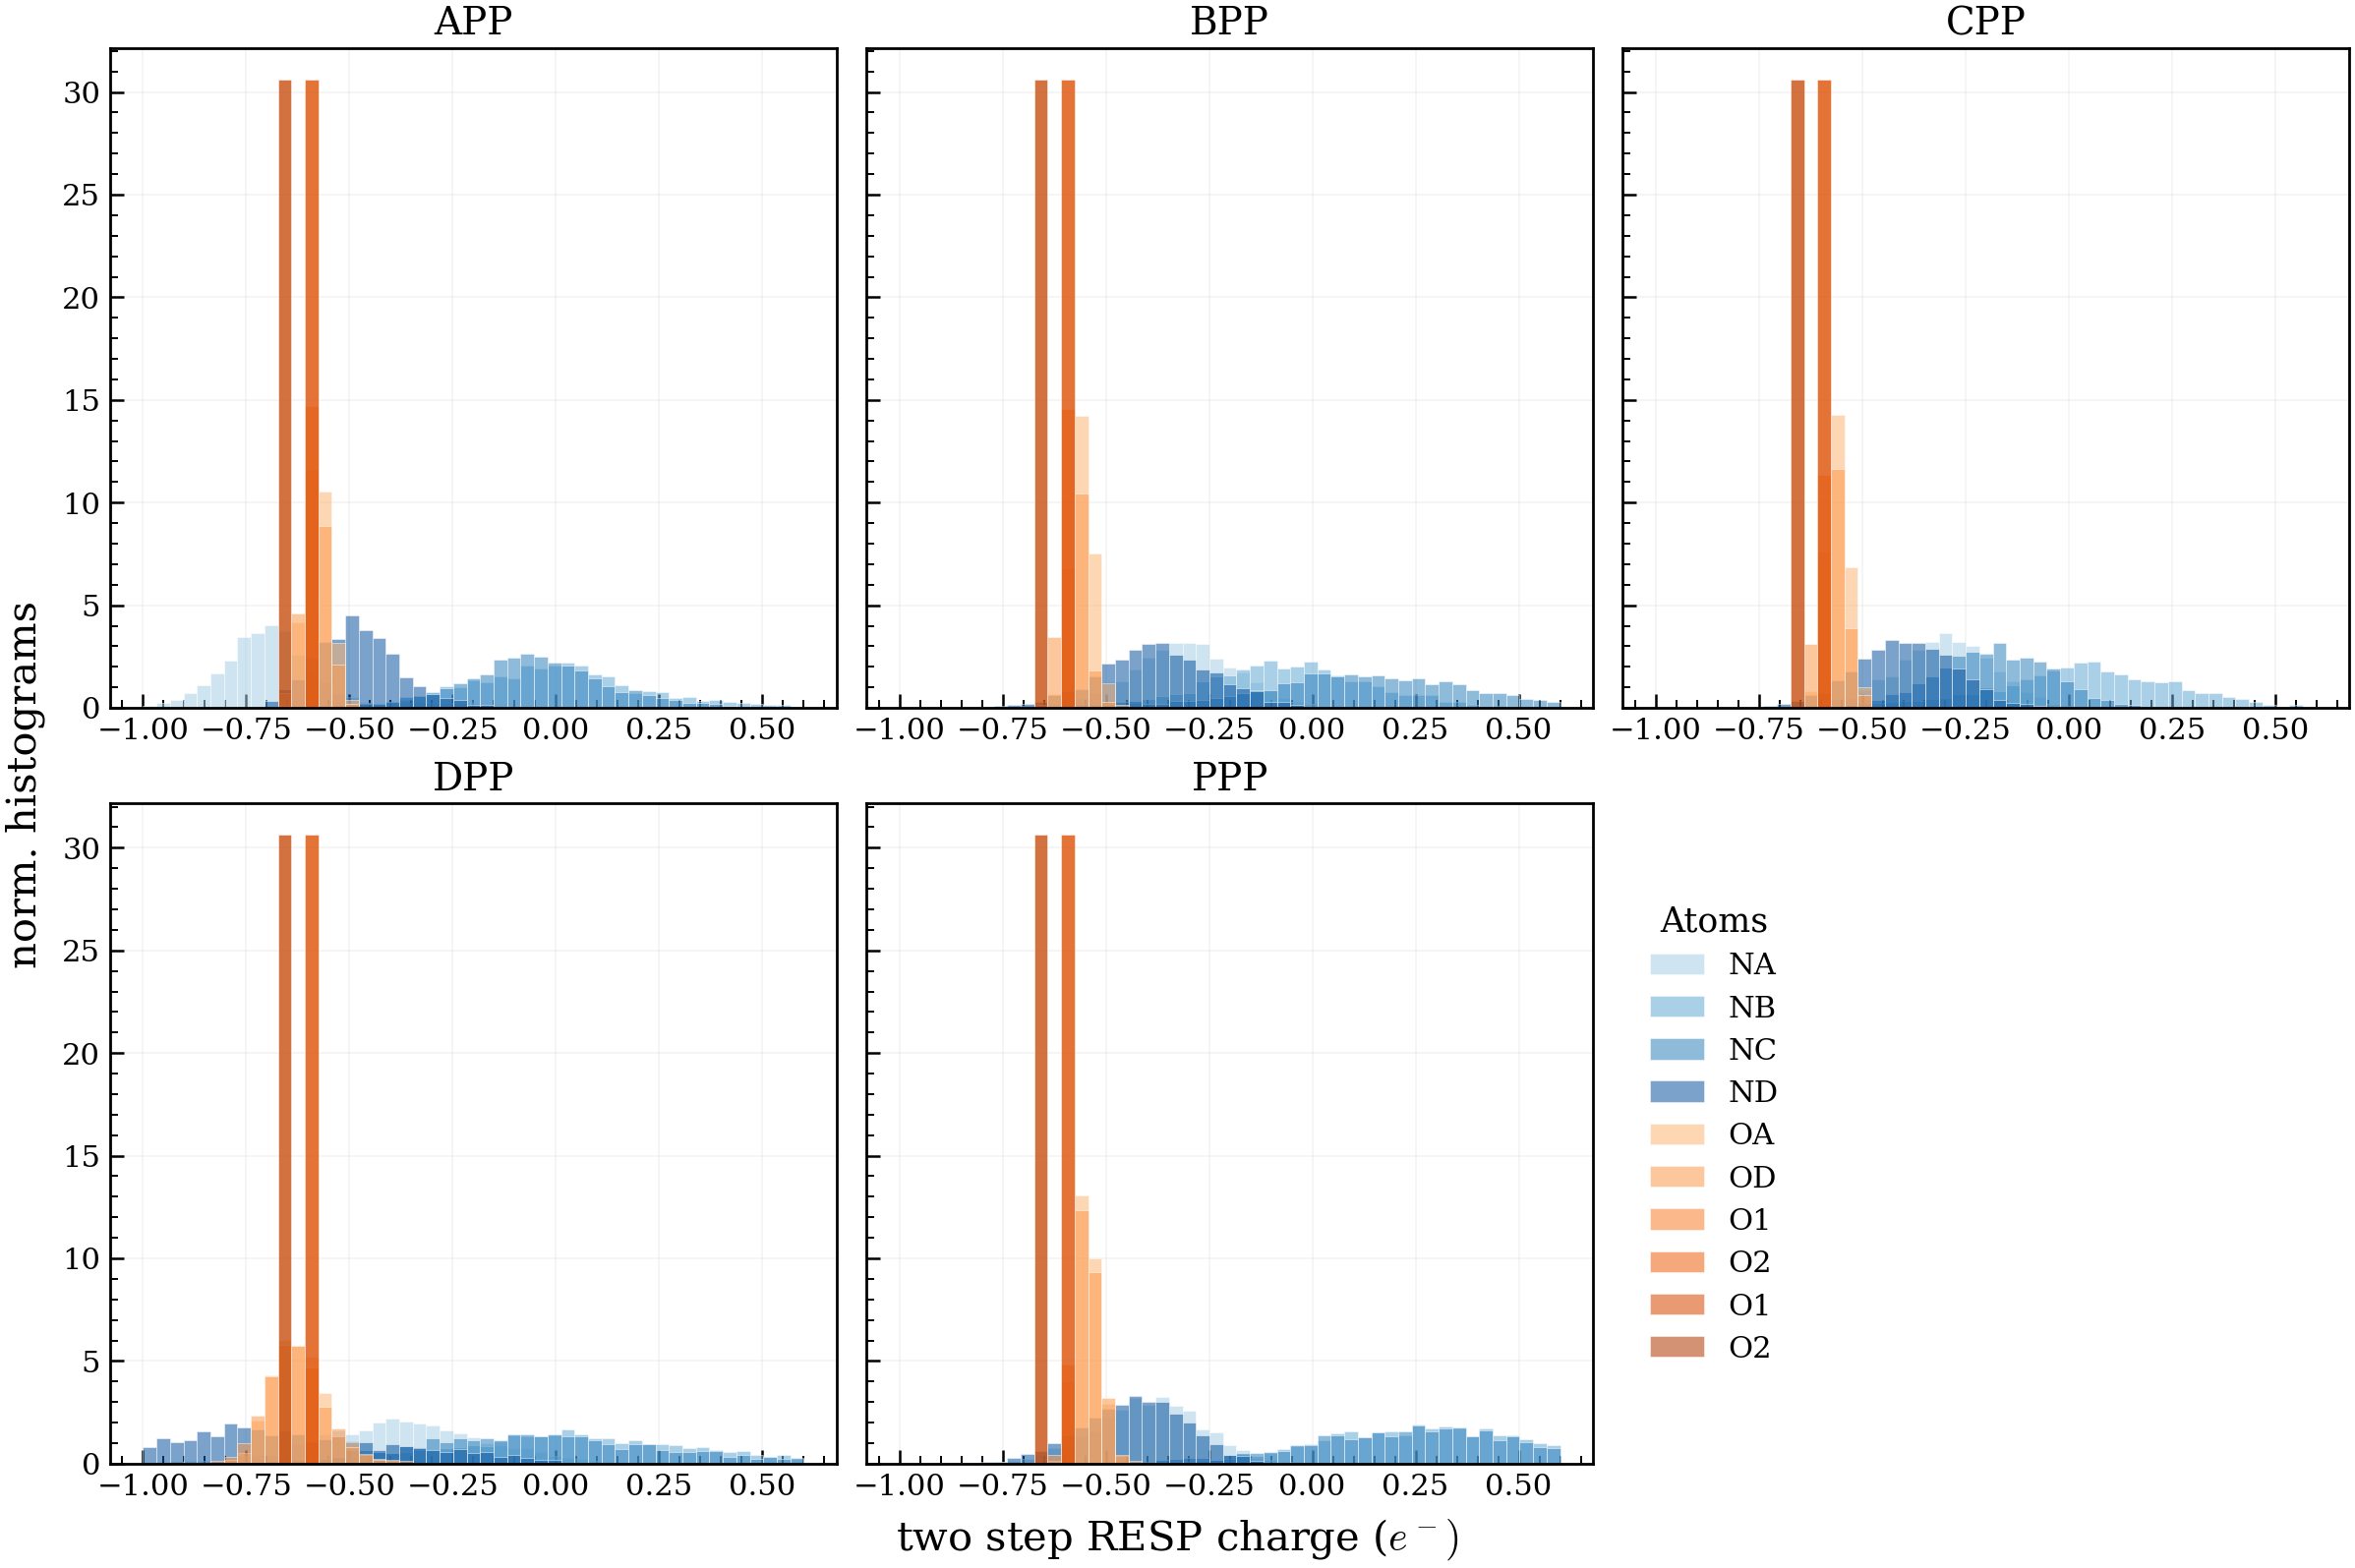

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 0.6, 50)

legend_handles, legend_labels = [], []
collect_legend = True

for ax, state in zip(axes[:-1], MICROSTATES):
    labels = datasets[state]["labels"]
    charges = datasets[state]["charges"]

    n_idx = [i for i, lbl in enumerate(labels) if lbl.startswith("N")]
    o_idx = [i for i, lbl in enumerate(labels) if lbl.startswith("O")]

    blues = plt.cm.Blues(np.linspace(0.35, 0.85, len(n_idx))) if n_idx else []
    oranges = plt.cm.Oranges(np.linspace(0.35, 0.85, len(o_idx))) if o_idx else []

    ax.set_title(state)
    ax.grid(alpha=0.3)

    for color, idx in zip(blues, n_idx):
        series = charges[idx]
        _, _, patches = ax.hist(
            series, bins=bins, density=True,
            alpha=0.55, color=color, edgecolor="white",
            linewidth=0.3, label=labels[idx]
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(labels[idx])

    for color, idx in zip(oranges, o_idx):
        series = charges[idx]
        _, _, patches = ax.hist(
            series, bins=bins, density=True,
            alpha=0.55, color=color, edgecolor="white",
            linewidth=0.3, label=labels[idx]
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(labels[idx])

    collect_legend = False

# dedicate the sixth subplot to a legend
legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(legend_handles, legend_labels,
                 loc="center left", frameon=False, title="Atoms")

fig.supxlabel(r"two step RESP charge ($e^-)$")
fig.supylabel("norm. histograms")
#fig.tight_layout()

Text(0.02, 0.5, 'norm. histograms')

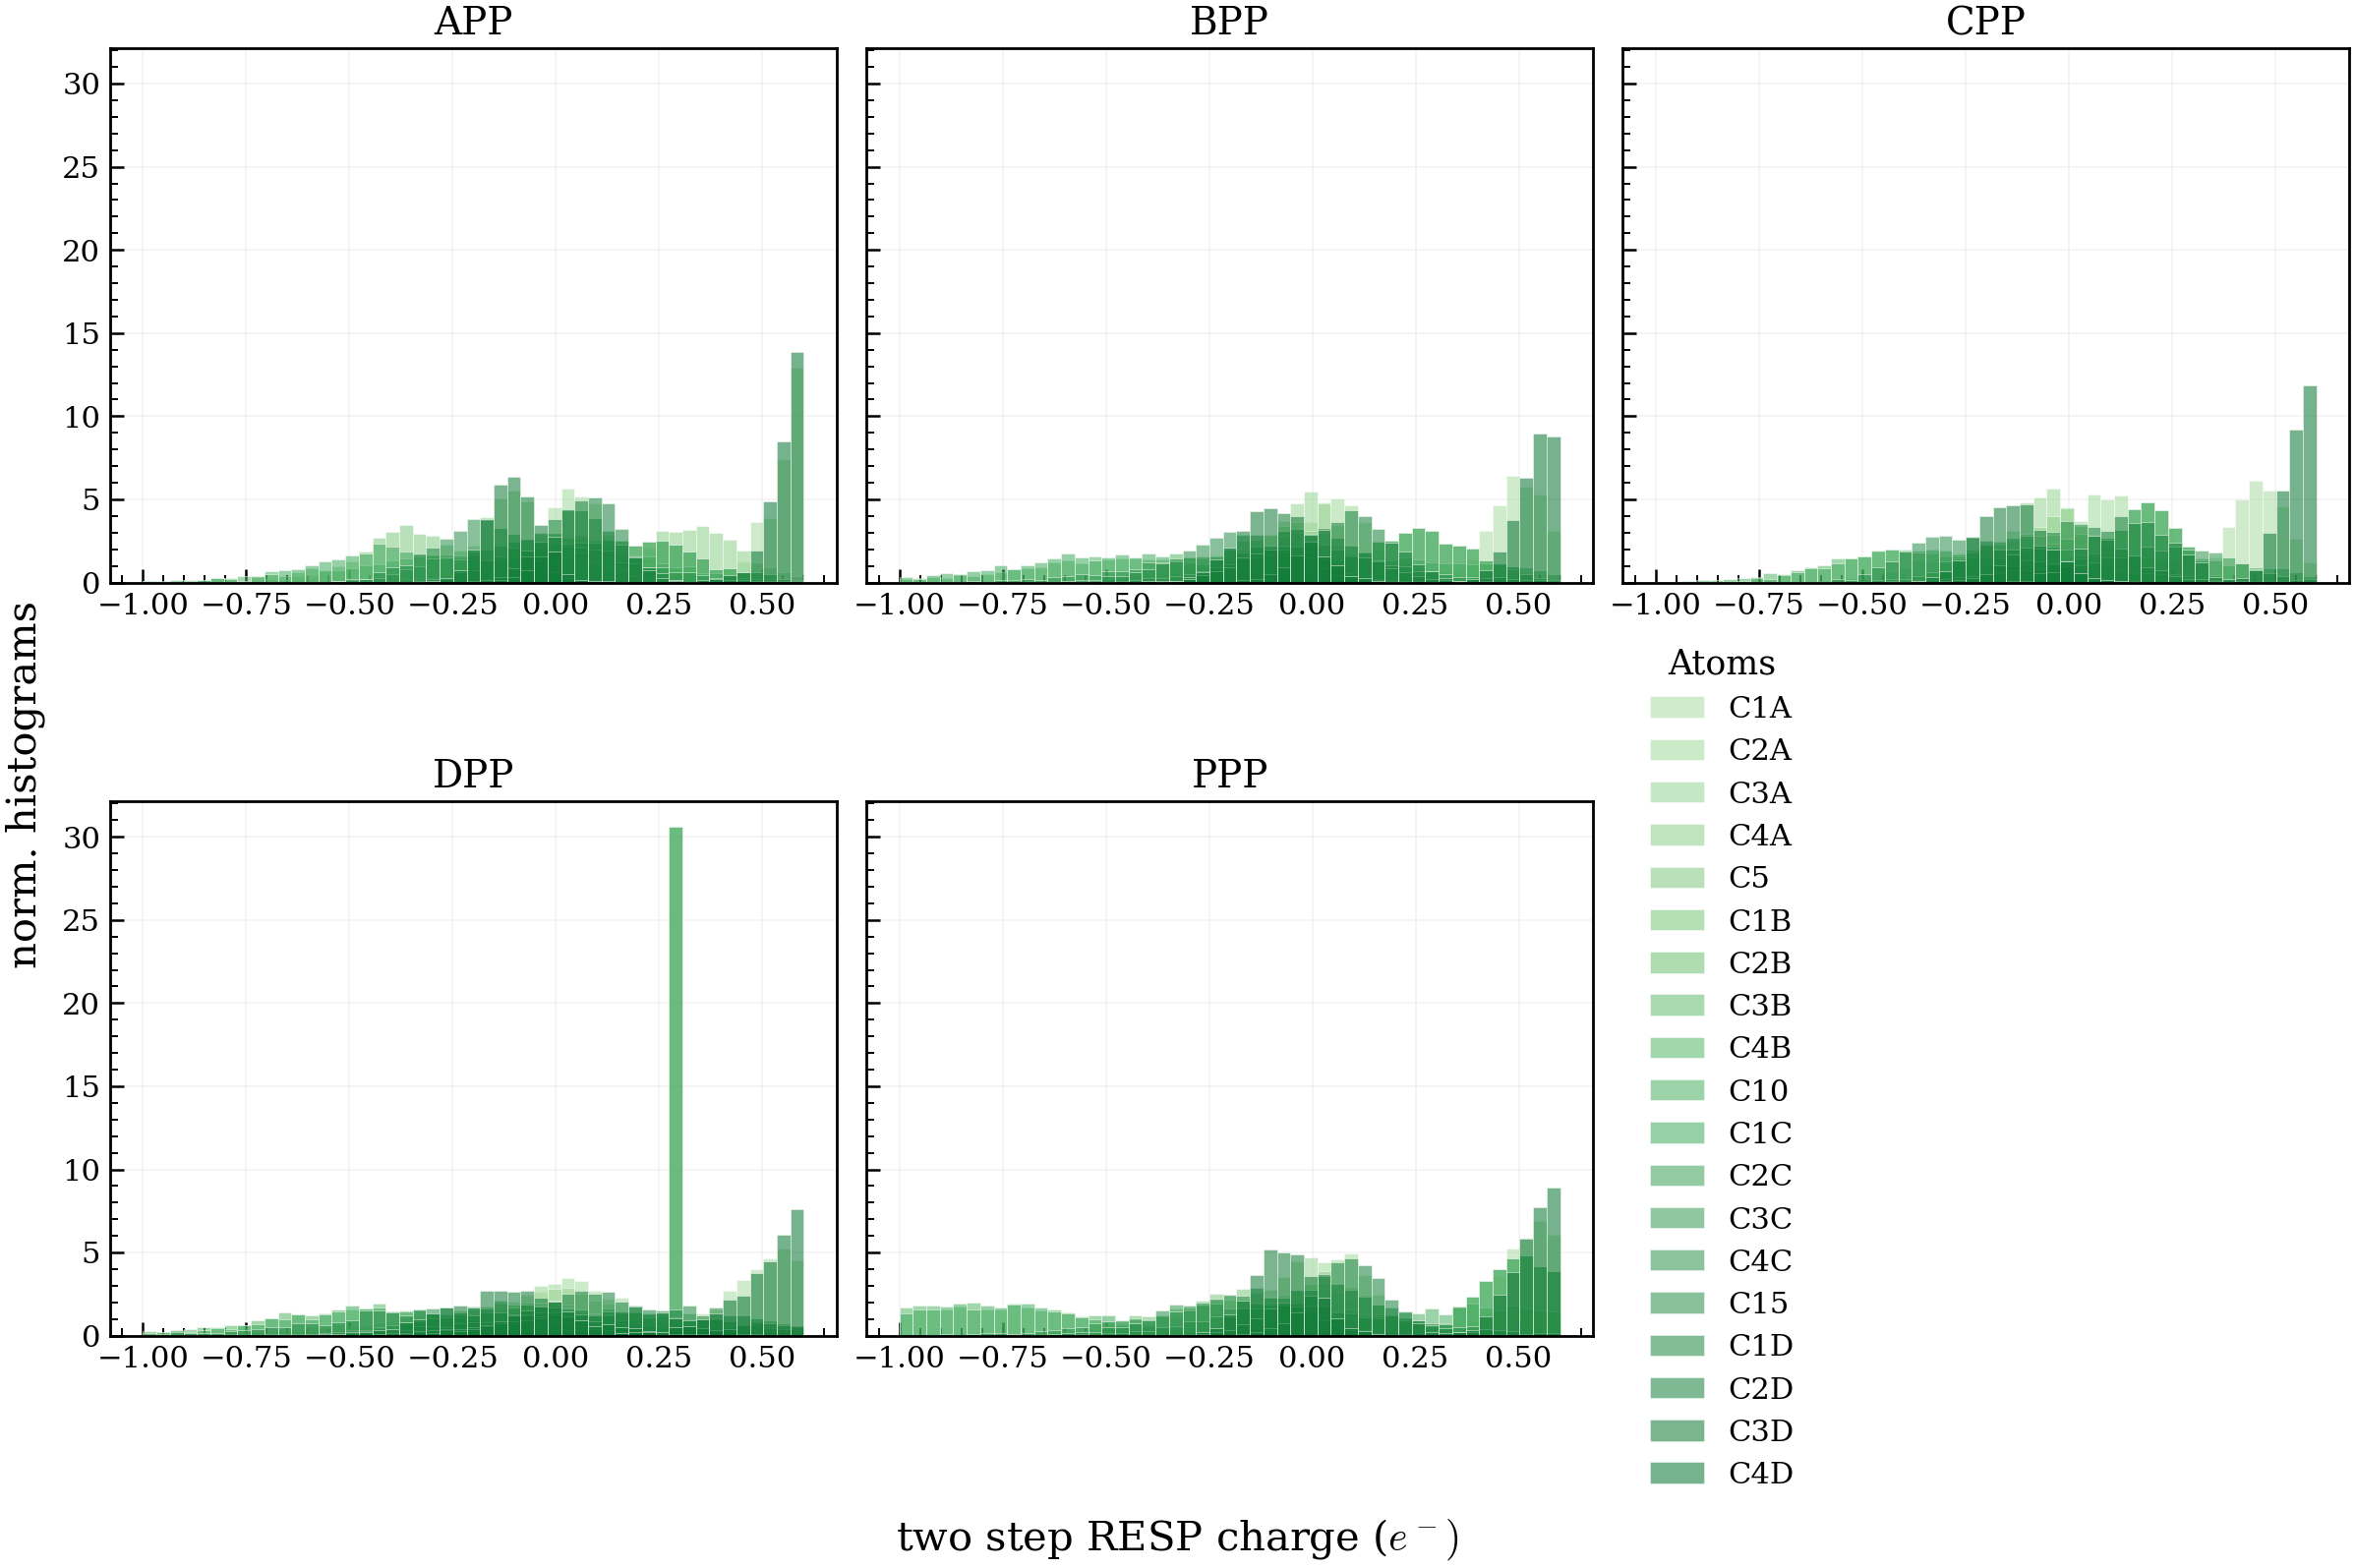

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 0.6, 50)

legend_handles, legend_labels = [], []
collect_legend = True

for ax, state in zip(axes[:-1], MICROSTATES):
    labels = carbon_datasets[state]["labels"]
    charges = carbon_datasets[state]["charges"]

    c_idx = range(len(labels))
    greens = plt.cm.Greens(np.linspace(0.35, 0.85, len(c_idx))) if labels.size else []

    ax.set_title(state)
    ax.grid(alpha=0.3)

    for color, idx in zip(greens, c_idx):
        series = charges[idx]
        _, _, patches = ax.hist(
            series,
            bins=bins,
            density=True,
            alpha=0.55,
            color=color,
            edgecolor="white",
            linewidth=0.3,
            label=labels[idx],
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(labels[idx])

    collect_legend = False

legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(legend_handles, legend_labels,
                 loc="center left", frameon=False, title="Atoms")

fig.supxlabel(r"two step RESP charge ($e^-)$")
fig.supylabel("norm. histograms")

Text(0.02, 0.5, 'norm. histograms')

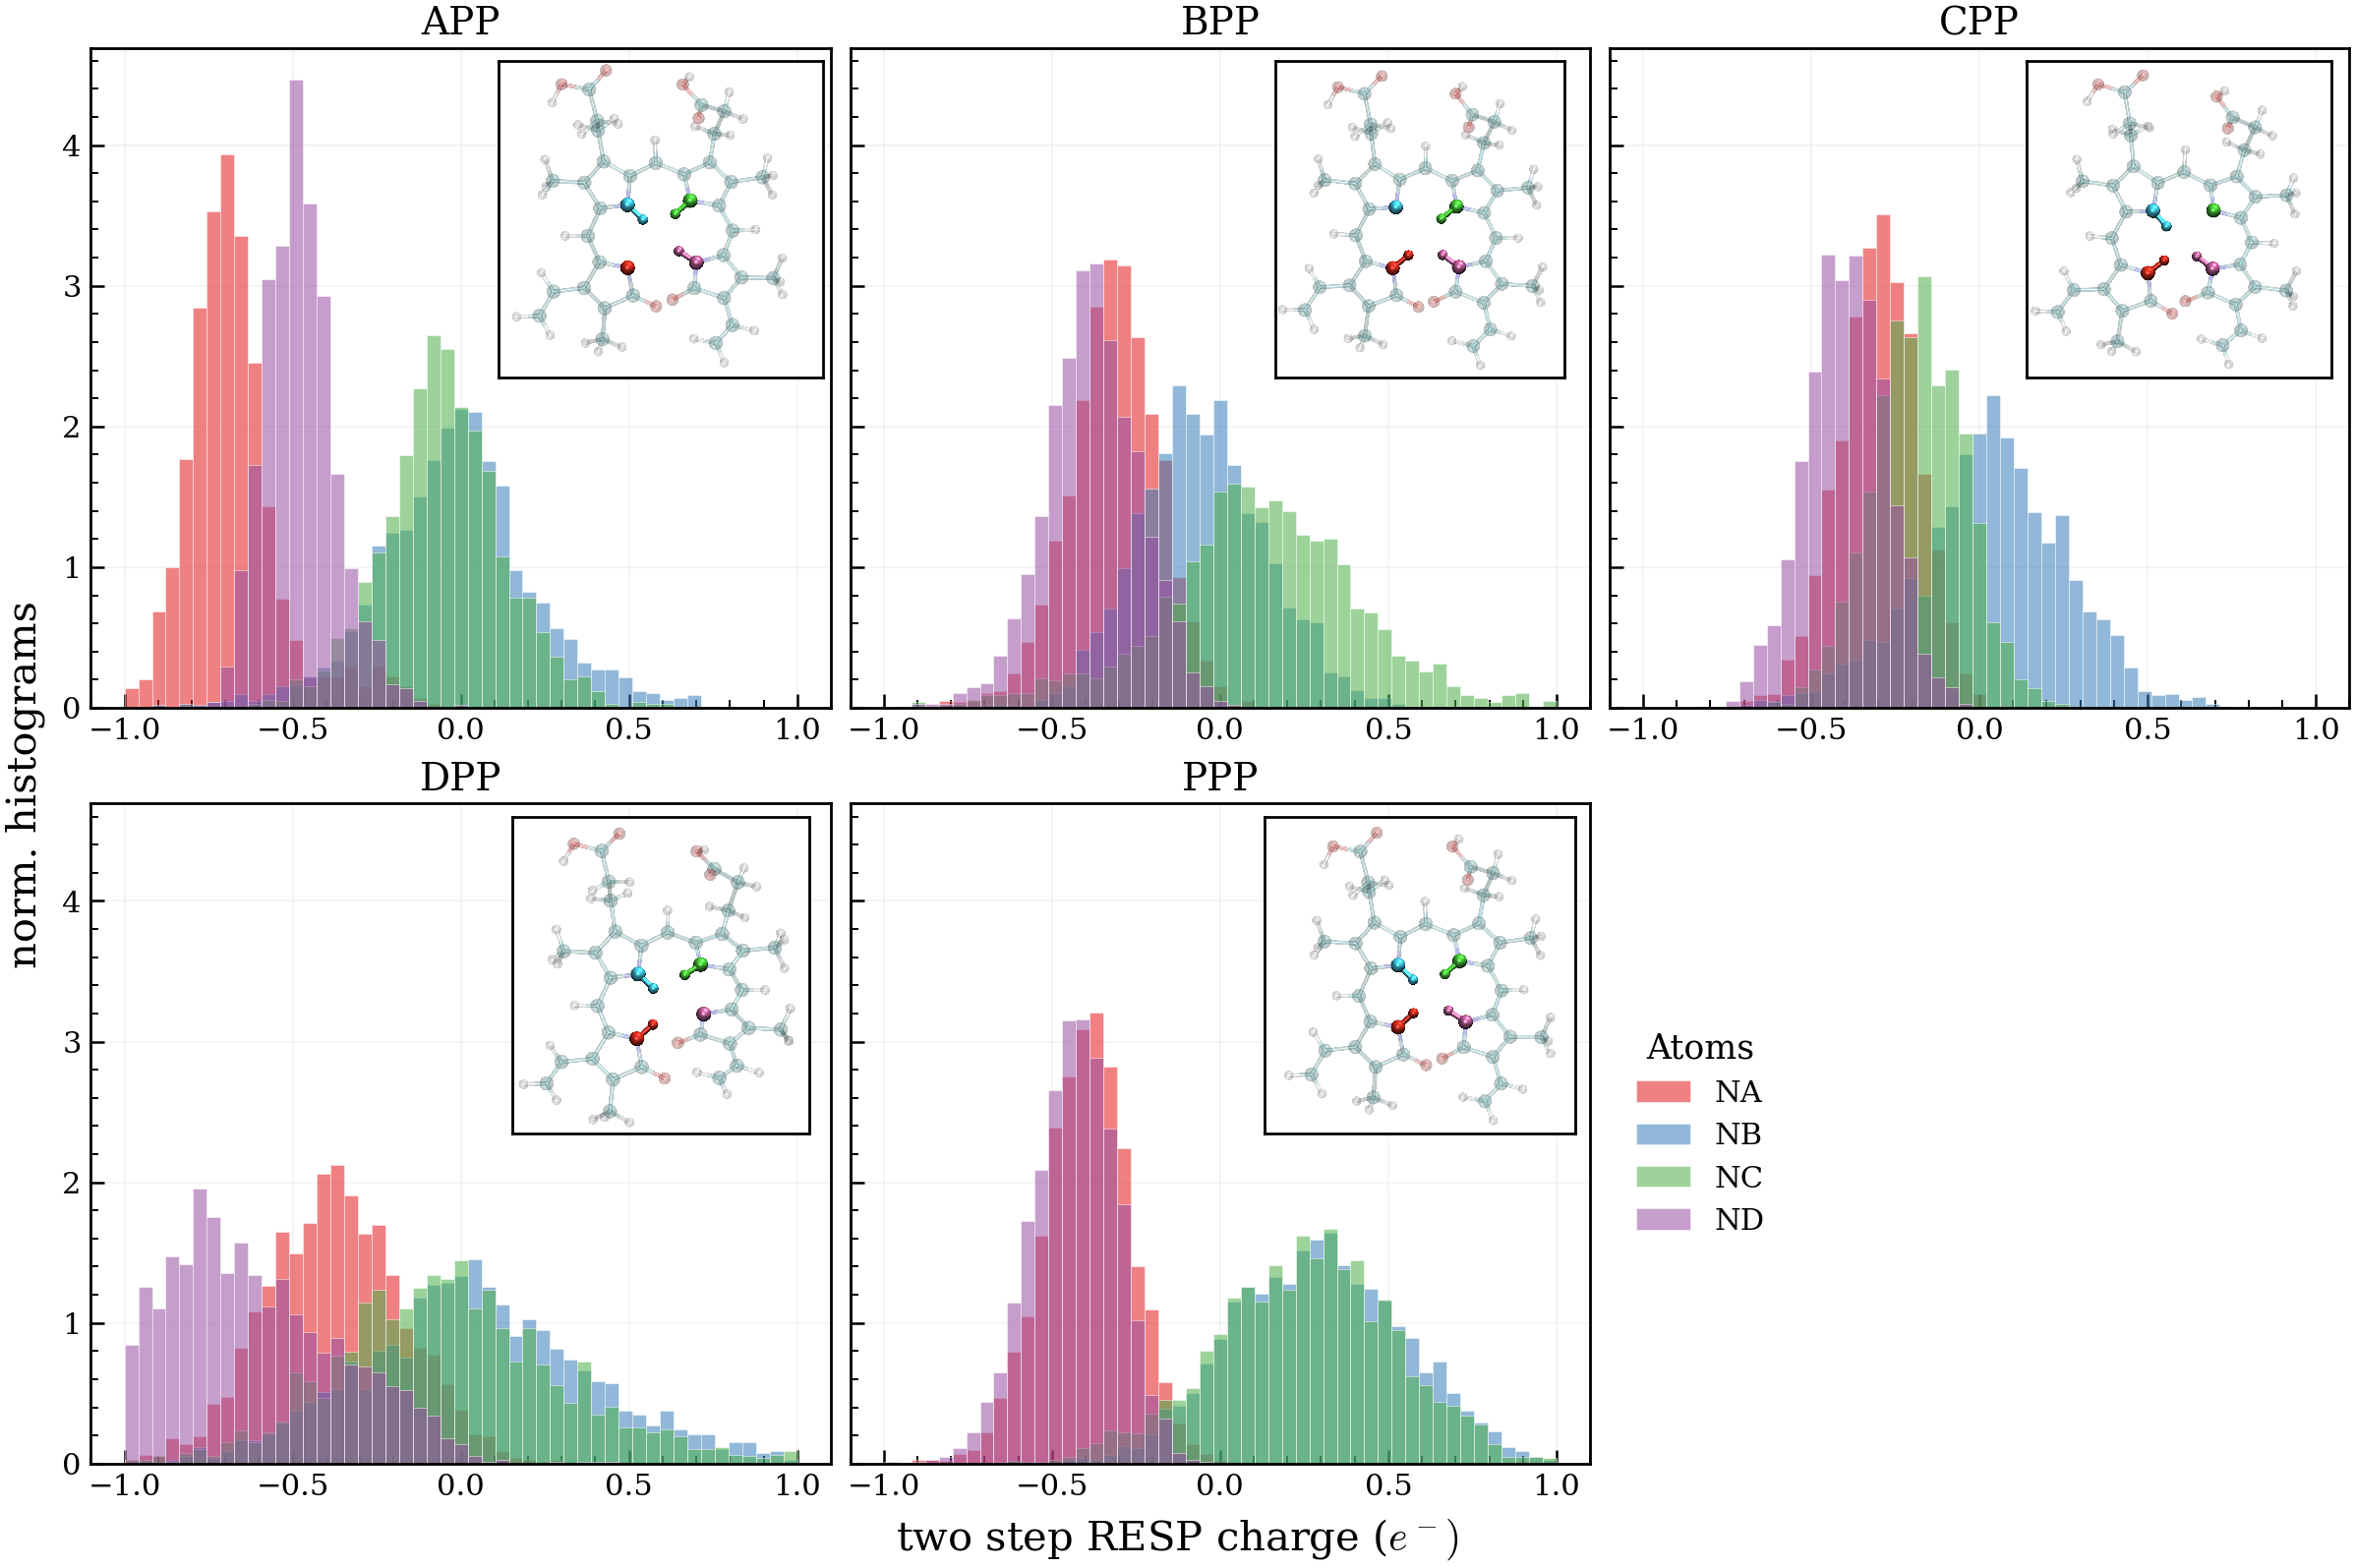

In [5]:
# Build a global color map once
all_labels = sorted({lbl for data in datasets.values() for lbl in data["labels"]})
palette = plt.get_cmap("Set1")              # qualitative, high-contrast palette
colors = [palette(i / max(1, len(all_labels) - 1)) for i in range(len(all_labels))]
color_map = dict(zip(all_labels, colors))


fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 1.0, 50)

legend_handles, legend_labels = [], []
collect_legend = True

for ax, state in zip(axes[:-1], MICROSTATES):
    labels = datasets[state]["labels"]
    charges = datasets[state]["charges"]
    img_path = INPUT_ROOT / state / "screenshot.png"
    ax.set_title(state)
    ax.grid(alpha=0.3)


    img = mpimg.imread(img_path)
    inset = ax.inset_axes([0.53, 0.50, 0.48, 0.48], transform=ax.transAxes)
    inset.imshow(img)
    inset.set_xticks([])
    inset.set_yticks([])

    for spine in inset.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(1)
    
    for label, series in zip(labels, charges):
        if not label.startswith("N"):
            continue

        color = color_map.get(label, "#333333")
        _, _, patches = ax.hist(
            series,
            bins=bins,
            density=True,
            alpha=0.55,
            color=color,
            edgecolor="white",
            linewidth=0.3,
            label=label,
        )
        if collect_legend:
            legend_handles.append(patches[0])
            legend_labels.append(label)

    collect_legend = False

legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(legend_handles, legend_labels,
                 loc="center left", frameon=False, title="Atoms")

fig.supxlabel(r"two step RESP charge ($e^-)$")
fig.supylabel("norm. histograms")


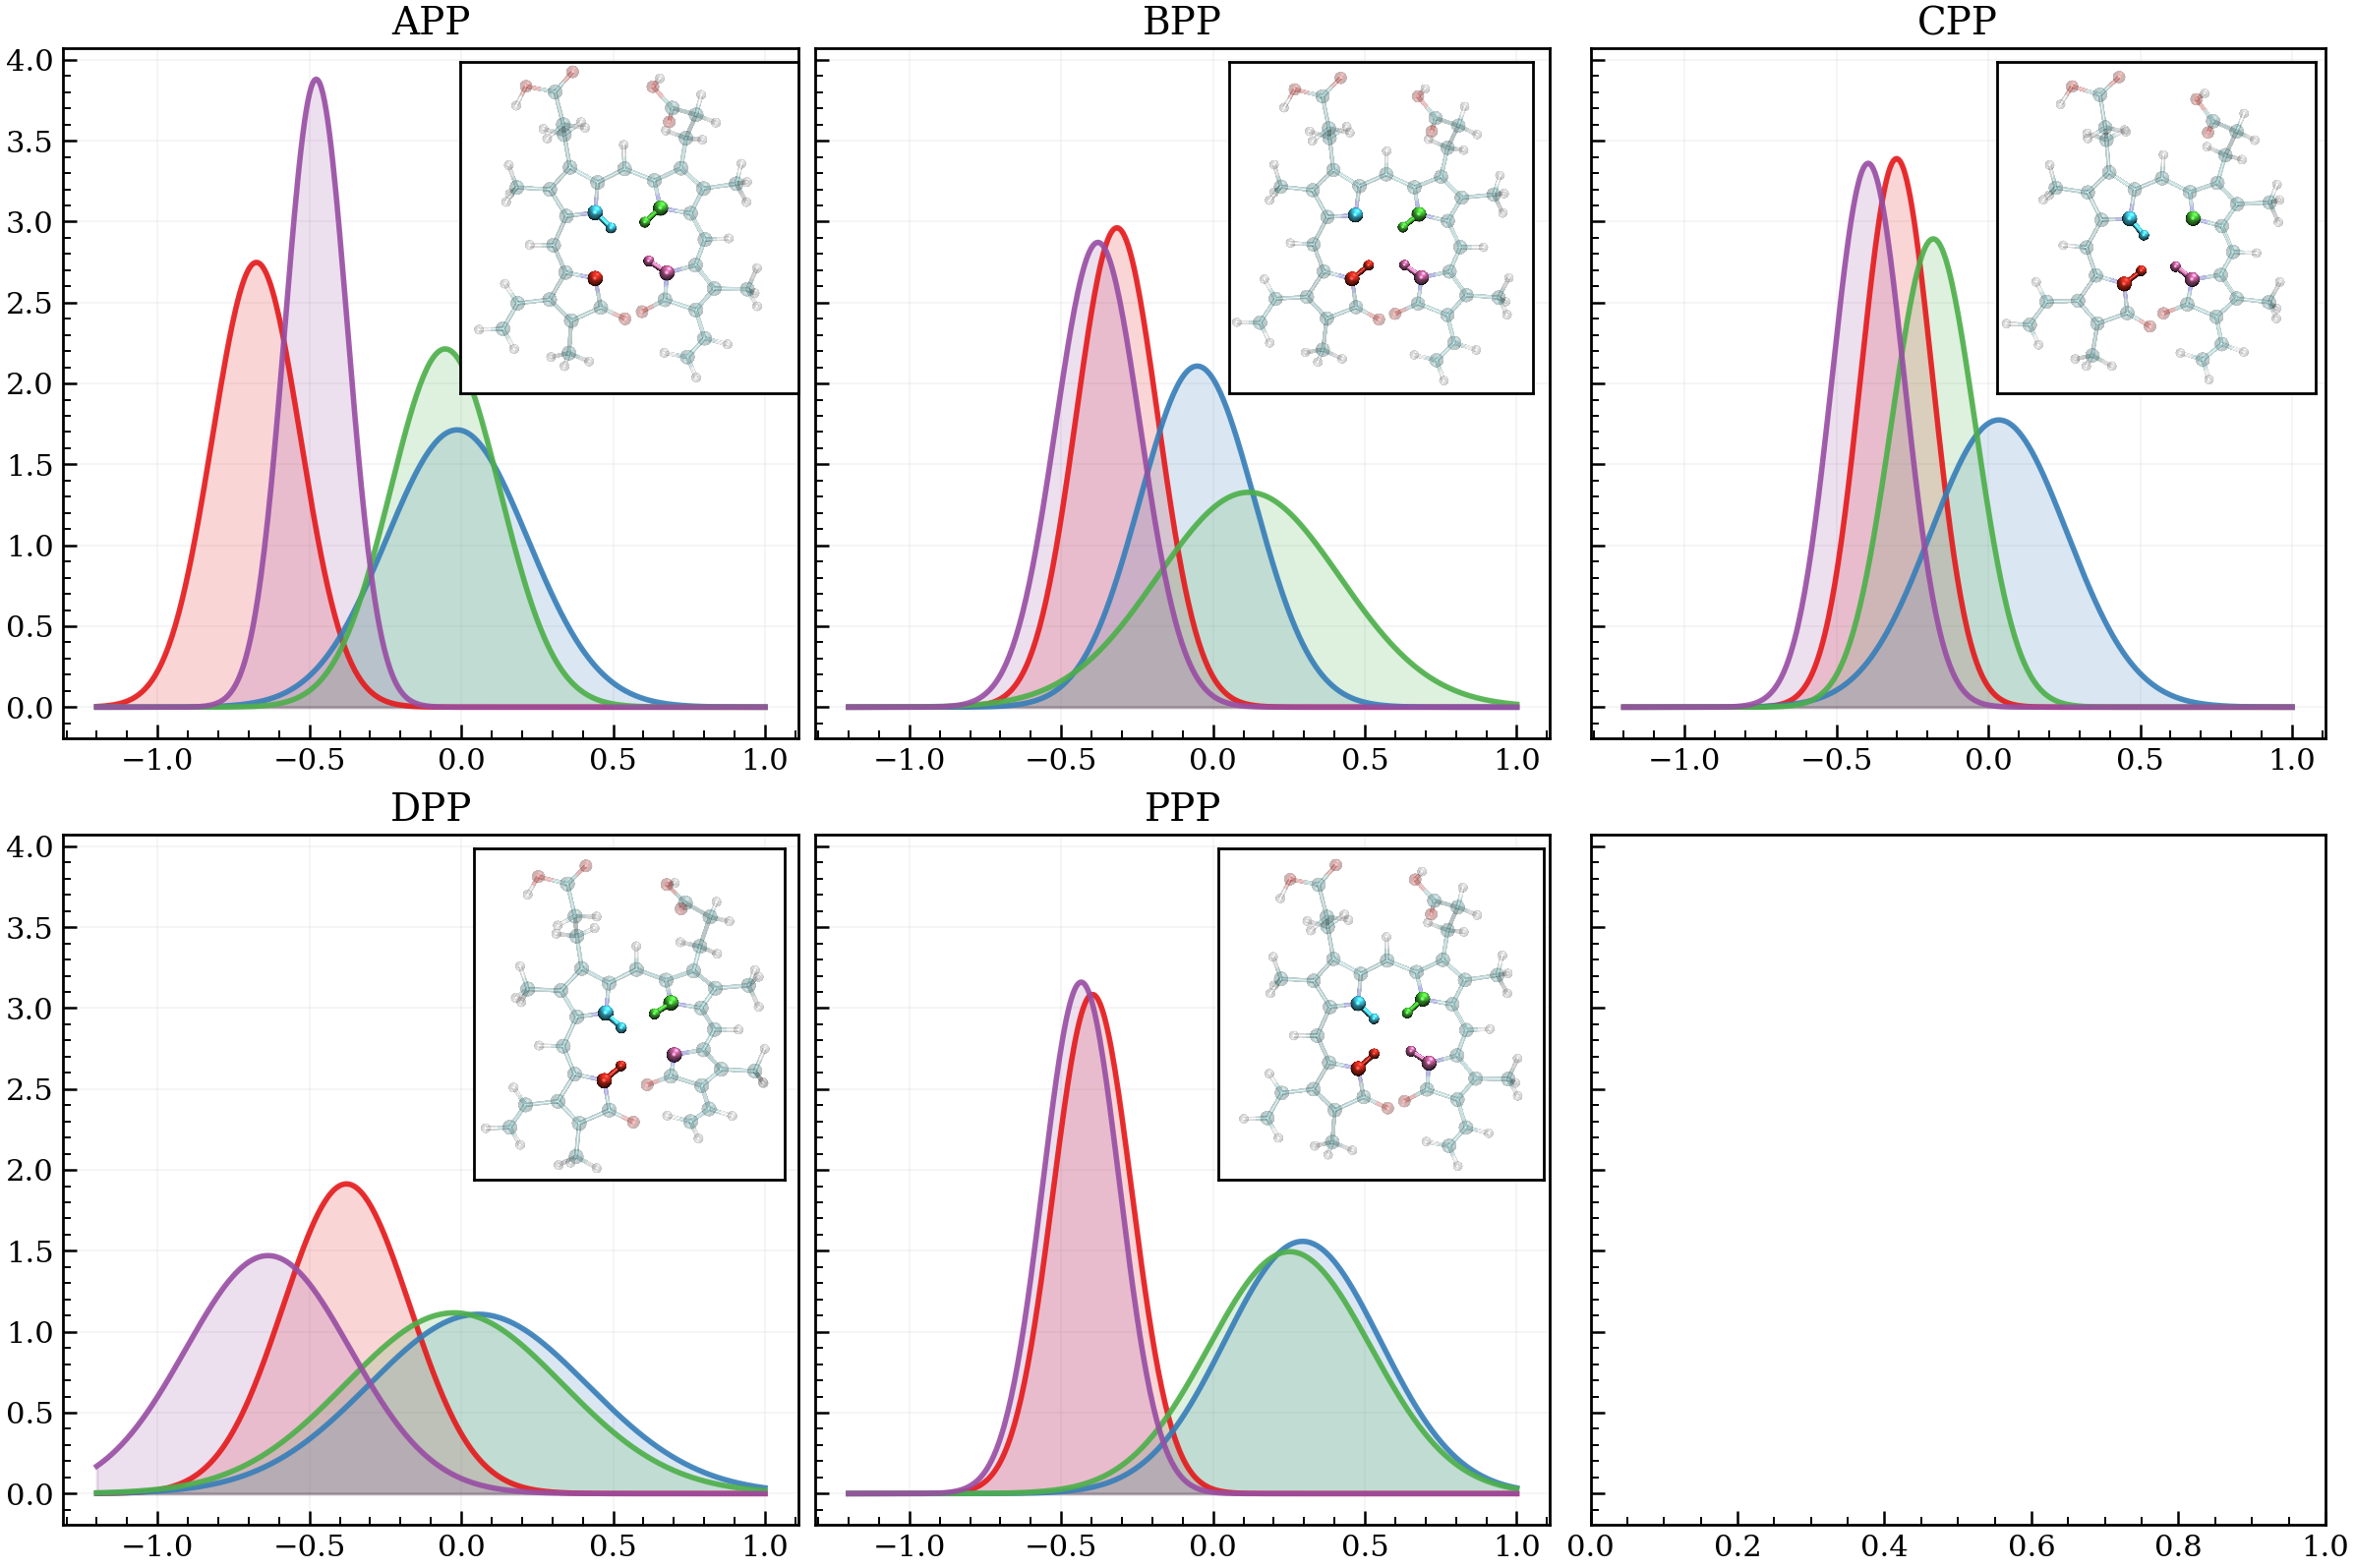

In [6]:
from matplotlib.lines import Line2D
from collections import defaultdict

# Build a global color map once
all_labels = sorted({lbl for data in datasets.values() for lbl in data["labels"]})
palette = plt.get_cmap("Set1")              # qualitative, high-contrast palette
colors = [palette(i / max(1, len(all_labels) - 1)) for i in range(len(all_labels))]
color_map = dict(zip(all_labels, colors))


fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.2, 1.0, 50)

legend_handles, legend_labels = [], []
collect_legend = True

x_grid = np.linspace(bins[0], bins[-1], 400)

stats = defaultdict(dict)


for ax, state in zip(axes[:-1], MICROSTATES):
    labels = datasets[state]["labels"]
    charges = datasets[state]["charges"]
    img_path = INPUT_ROOT / state / "screenshot.png"
    ax.set_title(state)
    ax.grid(alpha=0.3)


    img = mpimg.imread(img_path)
    inset = ax.inset_axes([0.53, 0.50, 0.48, 0.48], transform=ax.transAxes)
    inset.imshow(img)
    inset.set_xticks([])
    inset.set_yticks([])

    for spine in inset.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(1)
        
    for label, series in zip(labels, charges):
        if not label.startswith("N"): # this is where the nitrogens are selected!!!
            continue

        mu = np.mean(series)
        sigma = np.std(series, ddof=1)
        stats[state][label] = (mu, sigma)
        if sigma <= 0:  # nothing sensible to plot
            continue

        color = color_map.get(label, "#333333")
        y = 1.0 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_grid - mu) / sigma) ** 2)

        line, = ax.plot(x_grid, y, color=color, linewidth=2.0, alpha=0.9)
        ax.fill_between(x_grid, 0, y, color=color, alpha=0.18)

        if collect_legend:
            legend_handles.append(Line2D([0, 1], [0, 1], color=color, linewidth=2.0))
            legend_labels.append(label)

    collect_legend = False


In [7]:
def jdiv(mu1, sigma1, mu2, sigma2, eps=1e-12):
    """
    Definition of Jeffreys divergence is found on page 5 in "Statistical Inference Based on Divergence Measures" by Leandro Pardo
    J-divergence between N(mu1, sigma1^2) and N(mu2, sigma2^2):
      J = D_KL(N1||N2) + D_KL(N2||N1)
        = 0.5 * (sigma1^2/sigma2^2 + sigma2^2/sigma1^2 - 2)
          + 0.5 * (mu1 - mu2)**2 * (1/sigma1**2 + 1/sigma2**2)
    """
    s1 = max(float(sigma1), eps)
    s2 = max(float(sigma2), eps)
    dm = float(mu1) - float(mu2)
    return 0.5 * ((s1*s1)/(s2*s2) + (s2*s2)/(s1*s1) - 2.0) + 0.5 * (dm*dm) * (1.0/(s1*s1) + 1.0/(s2*s2))

state = "PPP"
want_pairs = [("NA", "ND"), ("NB", "NC")]

J_results = {}
missing = []
for a, b in want_pairs:
    a_stats = stats[state].get(a)
    b_stats = stats[state].get(b)
    if a_stats is None or b_stats is None:
        missing.append((a, b))
        continue
    (mu_a, sig_a), (mu_b, sig_b) = a_stats, b_stats
    if sig_a > 0 and sig_b > 0:
        J_results[(a, b)] = jdiv(mu_a, sig_a, mu_b, sig_b)

# (optional) quick print / save
print(f"J-divergences for {state}: {J_results}")
if missing:
    print(f"Missing labels in {state}: {missing}")

J-divergences for PPP: {('NA', 'ND'): 0.08597278857720916, ('NB', 'NC'): 0.029880147519402402}


Mean RESP charges by state and atom:
APP - C3B: 0.202002
APP - C2C: 0.202002
APP - CA: -0.034450
APP - CB: -0.012900
APP - CA: -0.034450
APP - CB: -0.012900
APP - HA1: 0.004150
APP - HA2: 0.004150
APP - HB1: 0.000250
APP - HB2: 0.000250
APP - HA1: 0.004150
APP - HA2: 0.004150
APP - HB1: 0.000250
APP - HB2: 0.000250
BPP - C3B: 0.266665
BPP - C2C: 0.266665
BPP - CA: -0.034450
BPP - CB: -0.012900
BPP - CA: -0.034450
BPP - CB: -0.012900
BPP - HA1: 0.004150
BPP - HA2: 0.004150
BPP - HB1: 0.000250
BPP - HB2: 0.000250
BPP - HA1: 0.004150
BPP - HA2: 0.004150
BPP - HB1: 0.000250
BPP - HB2: 0.000250
CPP - C3B: 0.180417
CPP - C2C: 0.180417
CPP - CA: -0.034450
CPP - CB: -0.012900
CPP - CA: -0.034450
CPP - CB: -0.012900
CPP - HA1: 0.004150
CPP - HA2: 0.004150
CPP - HB1: 0.000250
CPP - HB2: 0.000250
CPP - HA1: 0.004150
CPP - HA2: 0.004150
CPP - HB1: 0.000250
CPP - HB2: 0.000250
DPP - C3B: 0.285985
DPP - C2C: 0.285985
DPP - CA: -0.034450
DPP - CB: -0.012900
DPP - CA: -0.034450
DPP - CB: -0.012900
DPP

Text(0.02, 0.5, 'norm. histograms')

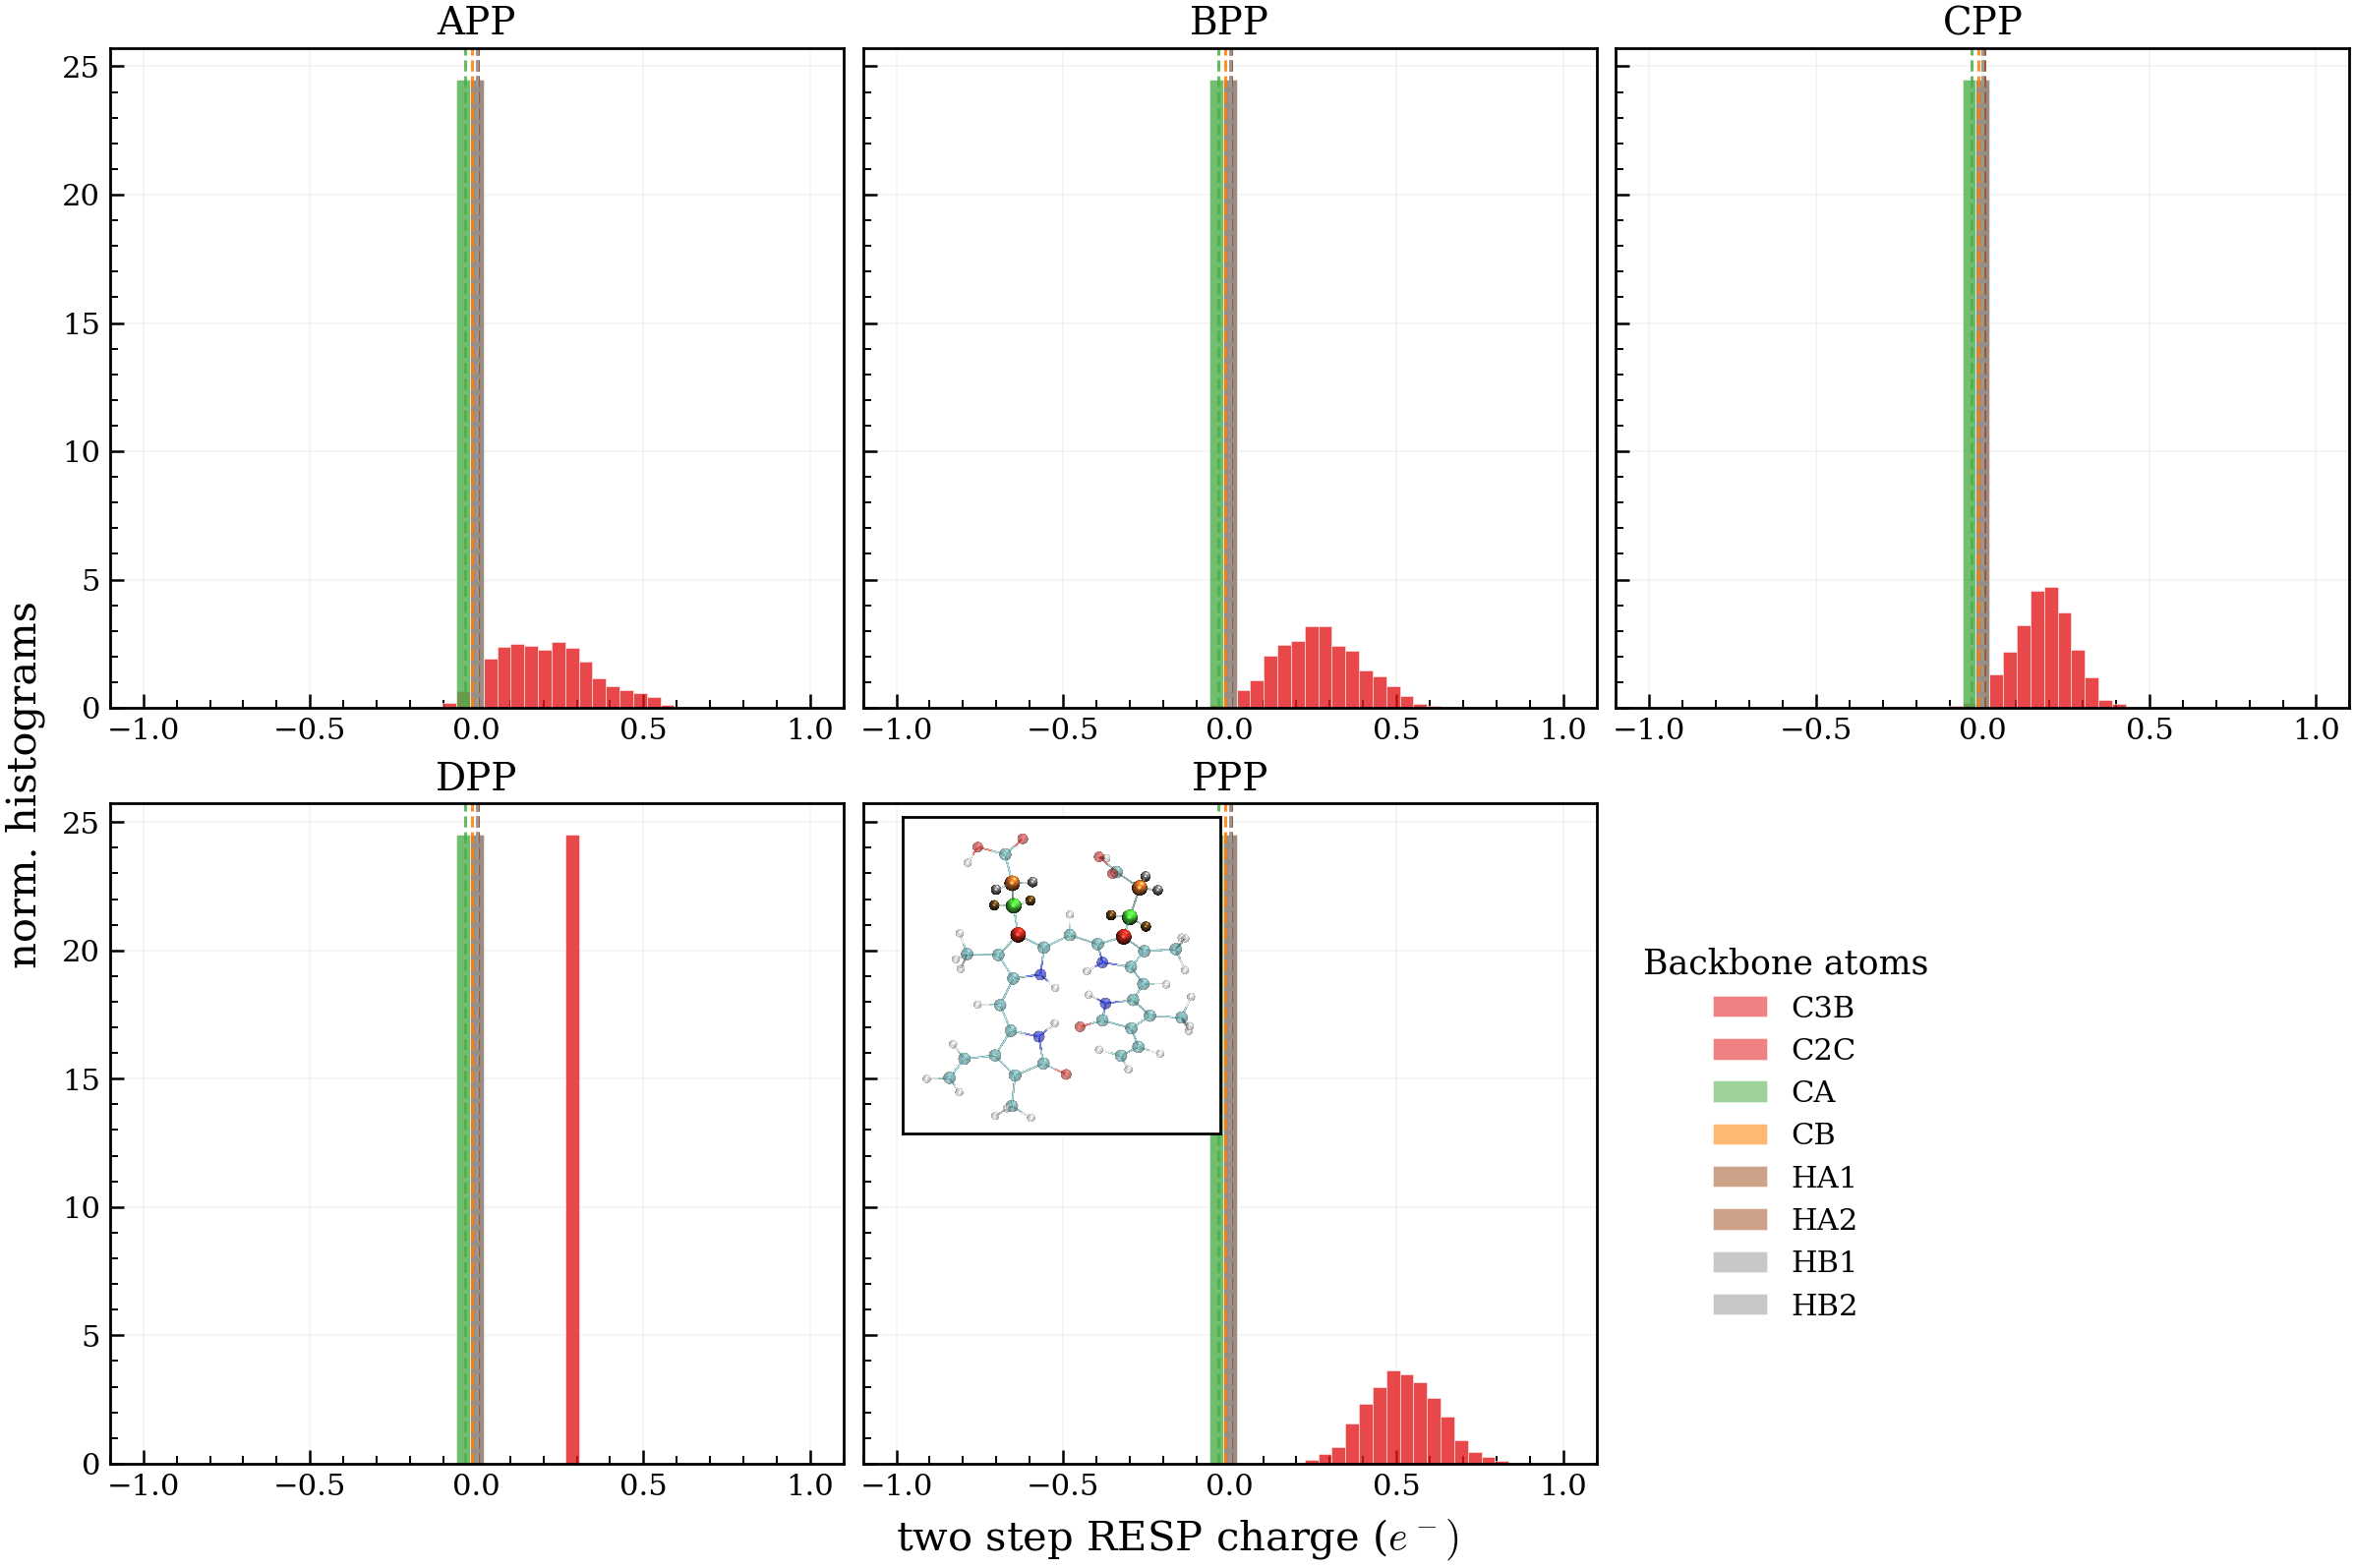

In [8]:
BACKBONE_ATOMS = ['C3B', 'C2C', 'CA', 'HA1', 'HA2', 'CB', 'HB1', 'HB2']
LINE_VALUES = {
    'CA':  -0.03445,
    'HA1':  0.00415,
    'HA2':  0.00415,
    'CB':  -0.01290,
    'HB1':  0.00025,
    'HB2':  0.00025,
}

COLOR_GROUP = {
    'C3B': 'C3B/C2C',
    'C2C': 'C3B/C2C',
    'HA1': 'HA1/HA2',
    'HA2': 'HA1/HA2',
    'HB1': 'HB1/HB2',
    'HB2': 'HB1/HB2',
}

def color_key(label):
    return COLOR_GROUP.get(label, label)

def merge_labels_and_series(state):
    pairs = []
    pairs.extend(zip(all_carbon_datasets[state]["labels"],
                     all_carbon_datasets[state]["charges"]))
    pairs.extend(zip(hydro_datasets[state]["labels"],
                     hydro_datasets[state]["charges"]))
    return pairs

palette = plt.get_cmap("Set1")
# Build color map once for any label we’ll color (histogram lines or reference lines)
present_keys = sorted({
    color_key(lbl)
    for state in MICROSTATES
    for lbl in (
        list(carbon_datasets[state]["labels"]) +
        list(hydro_datasets[state]["labels"])
    )
    if lbl in BACKBONE_ATOMS
}.union({color_key(lbl) for lbl in LINE_VALUES}))
colors = [palette(i / max(1, len(present_keys) - 1)) for i in range(len(present_keys))]
color_map = dict(zip(present_keys, colors))
DEFAULT_COLOR = "#333333"

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=True)
axes = axes.ravel()
bins = np.linspace(-1.0, 1.0, 50)

legend_handles, legend_labels = [], []
collect_legend = True
mean_records = []

for ax, state in zip(axes[:-1], MICROSTATES):
    label_series_pairs = merge_labels_and_series(state)
    img_path = INPUT_ROOT / state / "tail.png"

    ax.set_title(state)
    ax.grid(alpha=0.3)
    
    if state == "PPP":
        img = mpimg.imread(img_path)
        inset = ax.inset_axes([0.03, 0.50, 0.48, 0.48], transform=ax.transAxes)
        inset.imshow(img)
        inset.set_xticks([])
        inset.set_yticks([])
        for spine in inset.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor("black")
            spine.set_linewidth(1)

    for label, series in label_series_pairs:
        if label not in BACKBONE_ATOMS:
            continue

        color = color_map[color_key(label)]
        _, _, patches = ax.hist(
            series,
            bins=bins,
            density=True,
            alpha=0.55,
            color=color,
            edgecolor="white",
            linewidth=0.3,
            label=label,
        )
        mean_value = float(np.mean(series))
        formatted = f"{mean_value:.6f}"
        mean_records.append((state, label, formatted))
        if collect_legend and label not in legend_labels:
            legend_handles.append(patches[0])
            legend_labels.append(label)

    for label, x in LINE_VALUES.items():
        if label in BACKBONE_ATOMS:
            ax.axvline(
                x,
                color=color_map[color_key(label)],
                linestyle="--",
                linewidth=1.1,
                alpha=0.85,
            )

    collect_legend = False

if mean_records:
    print("Mean RESP charges by state and atom:")
    for state, label, formatted in mean_records:
        print(f"{state} - {label}: {formatted}")

legend_ax = axes[-1]
legend_ax.axis("off")
legend_ax.legend(
    legend_handles,
    legend_labels,
    loc="center left",
    frameon=False,
    title="Backbone atoms",
)

fig.supxlabel(r"two step RESP charge ($e^-)$")
fig.supylabel("norm. histograms")


In [9]:
print(mean_records)

[('APP', np.str_('C3B'), '0.202002'), ('APP', np.str_('C2C'), '0.202002'), ('APP', np.str_('CA'), '-0.034450'), ('APP', np.str_('CB'), '-0.012900'), ('APP', np.str_('CA'), '-0.034450'), ('APP', np.str_('CB'), '-0.012900'), ('APP', np.str_('HA1'), '0.004150'), ('APP', np.str_('HA2'), '0.004150'), ('APP', np.str_('HB1'), '0.000250'), ('APP', np.str_('HB2'), '0.000250'), ('APP', np.str_('HA1'), '0.004150'), ('APP', np.str_('HA2'), '0.004150'), ('APP', np.str_('HB1'), '0.000250'), ('APP', np.str_('HB2'), '0.000250'), ('BPP', np.str_('C3B'), '0.266665'), ('BPP', np.str_('C2C'), '0.266665'), ('BPP', np.str_('CA'), '-0.034450'), ('BPP', np.str_('CB'), '-0.012900'), ('BPP', np.str_('CA'), '-0.034450'), ('BPP', np.str_('CB'), '-0.012900'), ('BPP', np.str_('HA1'), '0.004150'), ('BPP', np.str_('HA2'), '0.004150'), ('BPP', np.str_('HB1'), '0.000250'), ('BPP', np.str_('HB2'), '0.000250'), ('BPP', np.str_('HA1'), '0.004150'), ('BPP', np.str_('HA2'), '0.004150'), ('BPP', np.str_('HB1'), '0.000250'), 